In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import utils
import torch
from sklearn.model_selection import train_test_split
import pickle
# train svm, lr
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import os
from model import Model

In [3]:
%load_ext autoreload
%autoreload 2

# Load data

In [4]:
config = utils.read_config()
# set seeds
utils.set_seeds(config['seed'])
behaviour_data, spikes = utils.load_dataset(config)
# consider data from only t = -1
# time_from = int(1/bin_len)
# behaviour_data, spikes = [x[time_from:, :] for x in behaviour_data], [x[time_from:, :] for x in spikes]
num_trials, time_bins, emissions_dim = np.array(spikes).shape
stim_idx, choice_idx, amp_idx = 6, 3, -1
stim = [x[0, stim_idx] for x in behaviour_data]
choice = [x[0, choice_idx] for x in behaviour_data]
amp = [x[0, amp_idx] for x in behaviour_data]
num_contacts = [np.sum(x[:, -9:-5], axis=1) for x in behaviour_data]
# concat them
behaviour_data = np.stack((stim, choice), axis=1)
# convert to torch tensors
behaviour_data = np.array(behaviour_data)
# behaviour_data = torch.tensor(behaviour_data, dtype=torch.float32)
spikes = np.array(spikes)
# create dataloader with random sampling for training and testing
# split data into training and testing
# behaviour_data_train, behaviour_data_test, spikes_train, spikes_test = train_test_split(behaviour_data, spikes, test_size=0.3, random_state=42)
behaviour_data_train, behaviour_data_test, spikes_train, spikes_test = train_test_split(behaviour_data, spikes, test_size=0.2, random_state=16)
trials_train, trials_test = len(behaviour_data_train), len(behaviour_data_test)
# distribution of choice and stimulus in test
print("Train distribution of Stimulus: {}, Choice: {}".format(np.mean(behaviour_data_train[:, 0]), np.mean(behaviour_data_train[:, 1])))
print("Test distribution of Stimulus: {}, Choice: {}".format(np.mean(behaviour_data_test[:, 0]), np.mean(behaviour_data_test[:, 1])))
# labels
y_stim_train, y_stim_test = behaviour_data_train[:, 0], behaviour_data_test[:, 0]
y_choice_train, y_choice_test = behaviour_data_train[:, 1], behaviour_data_test[:, 1]

Train distribution of Stimulus: 0.5039370078740157, Choice: 0.3858267716535433
Test distribution of Stimulus: 0.40625, Choice: 0.40625


# Train simple models on spikes for upper bound

Max test accuracy (stimulus): 0.8125
Max test accuracy (choice): 0.84375


Text(0.5, 1.0, 'SVM')

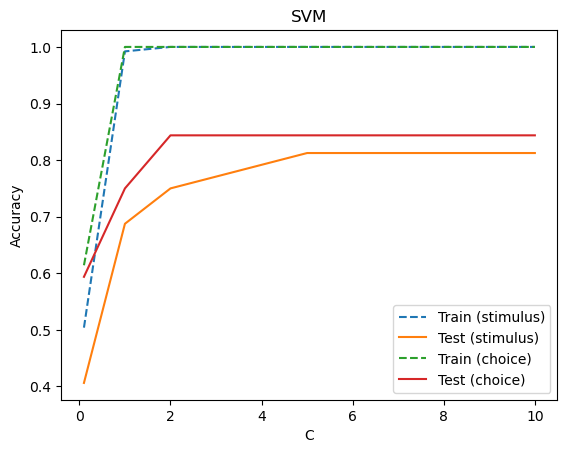

In [5]:
train_acc_stim, test_acc_stim = [], []
train_acc_choice, test_acc_choice = [], []
list_c = [0.1, 1, 2, 5, 10]
for which_beh, y_train, y_test in [('stim', y_stim_train, y_stim_test), ('choice', y_choice_train, y_choice_test)]:
    for c in list_c:
        # train svm
        clf = SVC(C=c)
        # clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)
        clf.fit(spikes_train.reshape(spikes_train.shape[0], -1), y_train)
        # predict
        pred_test = clf.predict(spikes_test.reshape(spikes_test.shape[0], -1))
        pred_train = clf.predict(spikes_train.reshape(spikes_train.shape[0], -1))
        # calculate accuracy
        test_accuracy = accuracy_score(y_test, pred_test)
        train_accuracy = accuracy_score(y_train, pred_train)
        if which_beh == 'stim':
            train_acc_stim.append(train_accuracy)
            test_acc_stim.append(test_accuracy)
        else:
            train_acc_choice.append(train_accuracy)
            test_acc_choice.append(test_accuracy)
# plot
plt.plot(list_c, train_acc_stim, label='Train (stimulus)', linestyle='--')
plt.plot(list_c, test_acc_stim, label='Test (stimulus)')
plt.plot(list_c, train_acc_choice, label='Train (choice)', linestyle='--')
plt.plot(list_c, test_acc_choice, label='Test (choice)')
# print max test accuracy
max_test_acc_stim = np.max(test_acc_stim)
max_test_acc_choice = np.max(test_acc_choice)
print("Max test accuracy (stimulus): {}".format(max_test_acc_stim))
print("Max test accuracy (choice): {}".format(max_test_acc_choice))

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SVM')


# Stimulus and Choice decoding from single/multiple bins

Max test accuracy (choice; C=1): 0.875
Max test accuracy (choice; C=5): 0.875
Max test accuracy (choice; C=10): 0.84375
Max test accuracy (choice; C=20): 0.8125


Text(0.5, 1.0, 'Test accuracy for different time bins for choice; window = 1')

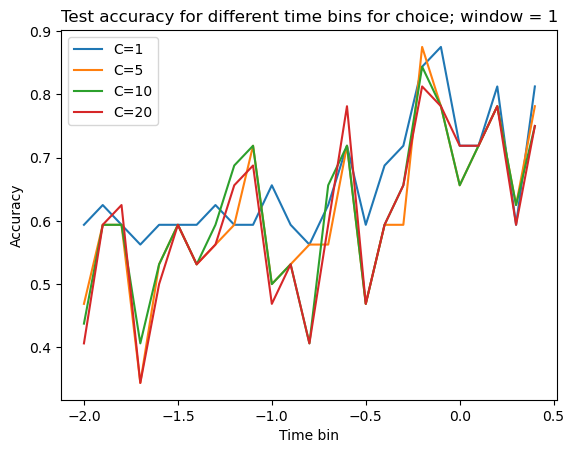

In [8]:
one_sided_window = 0
spikes_train_ = np.concatenate([np.zeros((trials_train, one_sided_window, emissions_dim)), spikes_train, np.zeros((trials_train, one_sided_window, emissions_dim))], axis=1)
spikes_test_ = np.concatenate([np.zeros((trials_test, one_sided_window, emissions_dim)), spikes_test, np.zeros((trials_test, one_sided_window, emissions_dim))], axis=1)
# behavior = 'stimulus'
behavior = 'choice'
list_c = [1, 5, 10, 20]
x = np.arange(25)/10 - 2
if behavior == 'stimulus':
    y_train, y_test = y_stim_train, y_stim_test
else:
    y_train, y_test = y_choice_train, y_choice_test
for c in list_c:
    train_acc, test_acc = [], []
    for t in range(25):
        # train svm
        clf = SVC(C=c)
        # clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)
        x_train = spikes_train_[:, t: t+2*one_sided_window+1].reshape(spikes_train_.shape[0], -1)
        x_test = spikes_test_[:, t: t+2*one_sided_window+1].reshape(spikes_test_.shape[0], -1)        
        clf.fit(x_train, y_train)
        # predict
        pred_test = clf.predict(x_test)
        pred_train = clf.predict(x_train)
        # calculate accuracy
        test_accuracy = accuracy_score(y_test, pred_test)
        train_accuracy = accuracy_score(y_train, pred_train)        
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
    # plot
    # plt.plot(list_c, train_acc_stim, label='Train (stimulus)', linestyle='--')
    plt.plot(x, test_acc, label='C={}'.format(c))
    # print max
    max_test_acc = np.max(test_acc)
    print("Max test accuracy ({}; C={}): {}".format(behavior, c, max_test_acc))

plt.xlabel('Time bin')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test accuracy for different time bins for {}; window = {}'.format(behavior, one_sided_window*2+1))


# Load model output

In [154]:
config = utils.read_config()
model = Model(config, input_dim=emissions_dim)
# folder_pth = 'results/dandi_sub-221CR_ses-20190515T160400/100_ms/'
folder_pth = 'results/sub-231CR_ses-20190924T161413/100_ms/'
# prefix = '1simplevae_'
# prefix = '2vaegp_'
# prefix = '3monotonicity_'
prefix = ''
with open(folder_pth + prefix + model.arch_name + '/res.pkl', 'rb') as f:
    all_data = pickle.load(f)
x_mu_train, z_mu_train, x_mu_test, z_mu_test = all_data[1], all_data[2], all_data[10], all_data[11]
x_mu_train, x_mu_test = x_mu_train.reshape(trials_train, time_bins, -1), x_mu_test.reshape(trials_test, time_bins, -1)

Not using moving average
Scheduler not implemented for GRU
Number of trainable parameters in VAE: 3522
No behavior decoder


FileNotFoundError: [Errno 2] No such file or directory: 'results/sub-231CR_ses-20190924T161413/100_ms/vae_[1, 1, 1]_8_2_bi/res.pkl'

# For each latent z, zero out time bins where z is not the argmax

Data:
* spikes: trials x bins x neurons
* x: trials x bins x x_dim
* z: trials x bins x 3/2

In [ ]:
decoding_from = 'spikes' # spikes or mu
# decoding_from = 'mu' # spikes or mu
# Thresholding based on z to keep only relevant time bins
z_dim = z_mu_train.shape[-1]
argmax_z_train = np.argmax(z_mu_train, axis=2)
argmax_z_test = np.argmax(z_mu_test, axis=2)

y_train, y_test = y_stim_train, y_stim_test
# y_train, y_test = y_choice_train, y_choice_test
list_c = [0.1, 0.5, 1, 2, 5, 10]

for i in range(z_dim):
    # set spikes where z is not i to 0
    if decoding_from == 'spikes':
        x_train, x_test = spikes_train.copy(), spikes_test.copy()
    else:
        x_train, x_test = x_mu_train.copy(), x_mu_test.copy()
    x_train[argmax_z_train != i] = 0
    x_test[argmax_z_test != i] = 0
    # print number of bins kept
    print("Number of time bins kept for z = {}: {}".format(i, np.mean(argmax_z_train == i)))
    for c in list_c:
        # train svm        
        clf = SVC(C=c)
        clf.fit(x_train.reshape(x_train.shape[0], -1), y_train)
        # predict
        pred_test = clf.predict(x_test.reshape(x_test.shape[0], -1))
        pred_train = clf.predict(x_train.reshape(x_train.shape[0], -1))
        # calculate accuracy
        test_accuracy = round(accuracy_score(y_test, pred_test), 3)
        train_accuracy = round(accuracy_score(y_train, pred_train), 3)
        print("C: {}, Train accuracy: {}, Test accuracy: {}".format(c, train_accuracy, test_accuracy))


# For each latent z, zero out time bins where z < threshold

In [ ]:
# y_train, y_test = y_stim_train, y_stim_test
y_train, y_test = y_choice_train, y_choice_test
threshold = 0.4

for i in range(z_dim):
    # set spikes where z < 0.5 to 0
    # x_train, x_test = spikes_train.copy(), spikes_test.copy()
    x_train, x_test = x_mu_train.copy(), x_mu_test.copy()
    x_train[z_mu_train[:, :, i] < threshold] = 0
    x_test[z_mu_test[:, :, i] < threshold] = 0
    # print number of bins kept
    print("Number of time bins kept for z = {}: {}".format(i, np.mean(z_mu_train[:, :, i] >= threshold)))
    # train svm
    clf = SVC(C=1)
    clf.fit(x_train.reshape(x_train.shape[0], -1), y_train)
    # predict
    pred_test = clf.predict(x_test.reshape(x_test.shape[0], -1))
    # calculate accuracy
    test_accuracy = accuracy_score(y_test, pred_test)
    print("Test accuracy (stimulus) after thresholding z: {}".format(test_accuracy))

# Train and test on time bin surrounding peak z

In [148]:
# decoding_from = 'spikes' # spikes or mu
decoding_from = 'mu' # spikes or mu
# Thresholding based on z to keep only relevant time bins
z_dim = z_mu_train.shape[-1]
x_dim = x_mu_train.shape[-1]
# y_train, y_test = y_stim_train, y_stim_test
y_train, y_test = y_choice_train, y_choice_test
list_c = [0.1, 0.5, 1, 2, 5]
one_sided_window = 0
# concatenate spikes with one sided window on both sides with zeros
spikes_train_ = np.concatenate([np.zeros((trials_train, one_sided_window, emissions_dim)), spikes_train, np.zeros((trials_train, one_sided_window, emissions_dim))], axis=1)
spikes_test_ = np.concatenate([np.zeros((trials_test, one_sided_window, emissions_dim)), spikes_test, np.zeros((trials_test, one_sided_window, emissions_dim))], axis=1)

for i in range(z_dim):
    # set spikes where z is not i to 0
    if decoding_from == 'spikes':
        x_train, x_test = spikes_train_.copy(), spikes_test_.copy()
    else:
        x_train = np.concatenate([np.zeros((trials_train, one_sided_window, x_dim)), x_mu_train, np.zeros((trials_train, one_sided_window, x_dim))], axis=1)
        x_test = np.concatenate([np.zeros((trials_test, one_sided_window, x_dim)), x_mu_test, np.zeros((trials_test, one_sided_window, x_dim))], axis=1)        
    # print(x_train.shape, x_test.shape)
    # find time bin where z peaks
    argmax_z_train = np.argmax(z_mu_train[:, :, i], axis=1)
    # print(argmax_z_train)
    argmax_z_test = np.argmax(z_mu_test[:, :, i], axis=1)    
    # take one sided window
    x_train = np.array([x[argmax_z_train[j]:argmax_z_train[j]+2*one_sided_window+1] for j, x in enumerate(x_train)]).reshape(x_train.shape[0], -1)
    x_test = np.array([x[argmax_z_test[j]:argmax_z_test[j]+2*one_sided_window+1] for j, x in enumerate(x_test)]).reshape(x_test.shape[0], -1)
    
    for c in list_c:
        # train svm        
        clf = SVC(C=c)
        # clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)
        clf.fit(x_train, y_train)
        # predict
        pred_test = clf.predict(x_test)
        pred_train = clf.predict(x_train)
        # calculate accuracy
        test_accuracy = round(accuracy_score(y_test, pred_test), 3)
        train_accuracy = round(accuracy_score(y_train, pred_train), 3)
        print("C: {}, Train accuracy: {}, Test accuracy: {}".format(c, train_accuracy, test_accuracy))
    print("")


C: 0.1, Train accuracy: 0.641, Test accuracy: 0.515
C: 0.5, Train accuracy: 0.758, Test accuracy: 0.576
C: 1, Train accuracy: 0.75, Test accuracy: 0.576
C: 2, Train accuracy: 0.766, Test accuracy: 0.545
C: 5, Train accuracy: 0.766, Test accuracy: 0.576

C: 0.1, Train accuracy: 0.641, Test accuracy: 0.515
C: 0.5, Train accuracy: 0.664, Test accuracy: 0.545
C: 1, Train accuracy: 0.688, Test accuracy: 0.545
C: 2, Train accuracy: 0.703, Test accuracy: 0.515
C: 5, Train accuracy: 0.719, Test accuracy: 0.545

C: 0.1, Train accuracy: 0.641, Test accuracy: 0.515
C: 0.5, Train accuracy: 0.641, Test accuracy: 0.515
C: 1, Train accuracy: 0.641, Test accuracy: 0.515
C: 2, Train accuracy: 0.648, Test accuracy: 0.515
C: 5, Train accuracy: 0.664, Test accuracy: 0.545

